<a href="https://colab.research.google.com/github/guzamak/hack-swift/blob/main/model_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pokenoi","key":"5dfcf645da6570670837e8bd049defbb"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d shrupyag001/philippines-rice-diseases

 94% 44.0M/46.8M [00:03<00:00, 22.9MB/s]
100% 46.8M/46.8M [00:03<00:00, 14.9MB/s]


In [8]:
!unzip /content/philippines-rice-diseases.zip

Archive:  /content/philippines-rice-diseases.zip
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (1).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (10).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (100).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (101).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (102).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (103).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (104).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (105).jpg  
  inflating: extra_resized_raw_images/extra_resized_raw_images/bacterial_leaf_blight/BLB (106).jpg  
  inflating: extra_resized_raw_images/extra_r

In [12]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [15]:
def create_dataframe(root_folder):
    file_paths = []
    labels = []

    for label_folder in glob(os.path.join(root_folder, '*')):
        label = os.path.basename(label_folder)
        for file_path in glob(os.path.join(label_folder, '*')):
            file_paths.append(file_path)
            labels.append(label)

    df = pd.DataFrame({'path': file_paths, 'label': labels})
    return df

In [16]:
root_folder = '/content/resized_raw_images/resized_raw_images'
df = create_dataframe(root_folder)

In [17]:
df

,path,label
0,/content/resized_raw_images/resized_raw_images...,rice_false_smut
1,/content/resized_raw_images/resized_raw_images...,rice_false_smut
2,/content/resized_raw_images/resized_raw_images...,rice_false_smut
3,/content/resized_raw_images/resized_raw_images...,rice_false_smut
4,/content/resized_raw_images/resized_raw_images...,rice_false_smut
...,...,...
1375,/content/resized_raw_images/resized_raw_images...,tungro_virus
1376,/content/resized_raw_images/resized_raw_images...,tungro_virus
1377,/content/resized_raw_images/resized_raw_images...,tungro_virus
1378,/content/resized_raw_images/resized_raw_images...,tungro_virus


In [18]:
!pip install -Uqq fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━

In [19]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [20]:
from fastbook import *

In [21]:
fields = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

In [22]:
dls = fields.dataloaders('/content/resized_raw_images/resized_raw_images')

In [23]:
dls.vocab #check class

['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bakanae', 'brown_spot', 'grassy_stunt_virus', 'healthy_rice_plant', 'narrow_brown_spot', 'ragged_stunt_virus', 'rice_blast', 'rice_false_smut', 'sheath_blight', 'sheath_rot', 'stem_rot', 'tungro_virus']

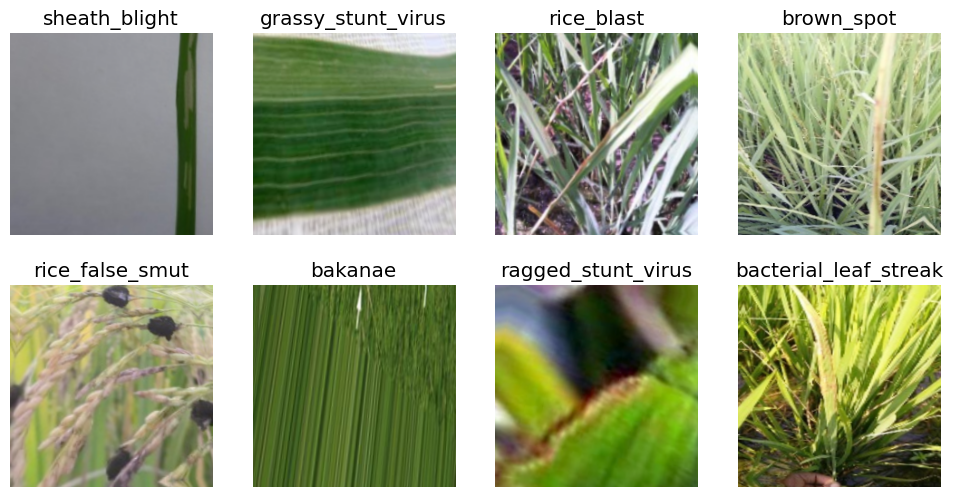

In [24]:
dls.train.show_batch(max_n=8, nrows=2)

In [25]:
learner = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 193MB/s]


SuggestedLRs(valley=0.0014454397605732083)

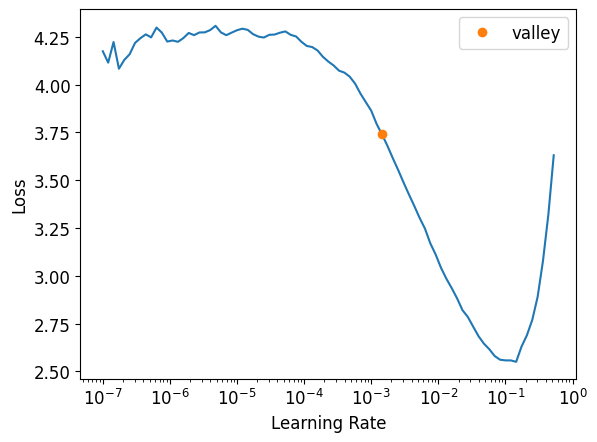

In [26]:
learner.lr_find() # หา learning rate ที่เหมาะสม

In [28]:
learner.fine_tune(epochs=25, base_lr=0.001)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.225475,0.482408,0.126812,0.873188,00:02


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.233718,0.505362,0.134058,0.865942,00:03
1,0.224561,0.502240,0.144928,0.855072,00:03
2,0.203269,0.517262,0.130435,0.869565,00:04
3,0.180529,0.517792,0.123188,0.876812,00:03
4,0.157548,0.496728,0.130435,0.869565,00:03
5,0.145420,0.553077,0.137681,0.862319,00:03
6,0.126958,0.520147,0.123188,0.876812,00:03
7,0.120671,0.549534,0.105072,0.894928,00:03
8,0.111503,0.486896,0.101449,0.898551,00:03
9,0.099414,0.625541,0.123188,0.876812,00:03


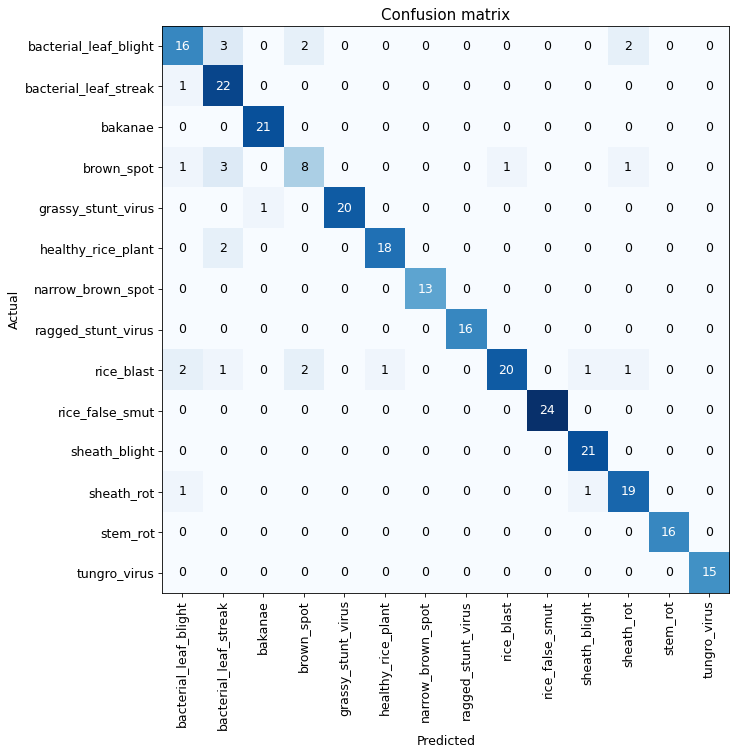

In [29]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(figsize=(10,10), dpi=75)

In [39]:
learner.export("rice_diseases_fastai.pkl")

In [40]:
from fastbook import *
model = load_learner('rice_diseases_fastai.pkl')

In [41]:
model.predict("/content/resized_raw_images/resized_raw_images/grassy_stunt_virus/Grassy_virus (1).jpeg")

('grassy_stunt_virus',
 tensor(4),
 tensor([1.3039e-06, 1.4522e-06, 1.6082e-06, 5.1906e-07, 9.9999e-01, 6.1888e-07, 6.1170e-06, 9.4499e-08, 3.3431e-07, 4.6365e-07, 2.3723e-08, 1.1732e-07, 5.9285e-08, 1.4459e-08]))

In [34]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 80.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.5/138.5 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 112.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 11.4 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl 

In [35]:
import gradio as gr

In [36]:
from io import BytesIO
from PIL import Image
def predict(picture):
    return model.predict(picture)[0]

In [37]:
interface = gr.Interface(fn=predict,
             inputs=gr.Image(type="pil"),
             outputs=gr.Textbox())

In [38]:
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://d515e96aa20185390e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
